# Garbage Classification using MobilenetV2

# Import Required Libraries

In [2]:
import numpy as np
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.layers import Normalization
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

print('setup successful!')

setup successful!


# Define Constants

In [3]:
# Increasing the image size didn't result in increasing the training accuracy
IMAGE_WIDTH = 224    
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


# Path where our data is located
base_path = "/Users/benji/Documents/Projects/Hack/garbage_classification"


# Dictionary to save our 12 classes
categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash',5:'brown-glass', 6:'white-glass', 7:'green-glass'}

print('defining constants successful!')

defining constants successful!


# Create DataFrame

We want to create a data frame that has in one column the filenames of all our images and in the other column the corresponding category. 
We Open the directories in the dataset one by one, save the filenames in the filenames_list and add the corresponding category in the categories_list

In [4]:
# # Add class name prefix to filename. So for example "/paper104.jpg" become "paper/paper104.jpg"
# def add_class_name_prefix(df, col_name):
#     df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
#     return df

# # list conatining all the filenames in the dataset
# filenames_list = []
# # list to store the corresponding category, note that each folder of the dataset has one class of data
# categories_list = []

# for category in categories:
#     filenames = os.listdir(base_path + categories[category])
    
#     filenames_list = filenames_list  +filenames
#     categories_list = categories_list + [category] * len(filenames)
    
# df = pd.DataFrame({
#     'filename': filenames_list,
#     'category': categories_list
# })

# df = add_class_name_prefix(df, 'filename')

# # Shuffle the dataframe
# df = df.sample(frac=1).reset_index(drop=True)

# print('number of elements = ' , len(df))

In [5]:
import os
import pandas as pd

# Initialize lists to store filenames and categories
filenames_list = []
categories_list = []

# Iterate over categories and collect filenames with their categories
for category in categories:
    # Construct the full path to the category folder
    category_path = os.path.join(base_path, categories[category])
    
    try:
        # List all files in the folder
        filenames = os.listdir(category_path)
        
        # Add the full path (with category prefix) for each file
        filenames_list.extend([f"{category}/{filename}" for filename in filenames])
        
        # Add the corresponding category for each file
        categories_list.extend([category] * len(filenames))
    except FileNotFoundError:
        print(f"Warning: Directory '{category_path}' not found. Skipping category '{category}'.")

# Create a DataFrame with filenames and categories
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

# Shuffle the DataFrame to randomize the order
df = df.sample(frac=1).reset_index(drop=True)

# Output the number of elements
print('Number of elements =', len(df))


Number of elements = 6283


In [6]:
import os
import pandas as pd

# Define categories, grouping different glass subcategories under 'glass'
categories = {
    0: 'paper',
    1: 'cardboard',
    2: 'plastic',
    3: 'metal',
    4: 'trash',
    5:'brown-glass', 
    6:'white-glass', 
    7:'green-glass'  # Glass subcategories
}

# Base path to the dataset
base_path = "/Users/benji/Documents/Projects/Hack/garbage_classification"

# Initialize lists to store filenames and categories
filenames_list = []
categories_list = []

# Iterate over the categories dictionary
for key, value in categories.items():
    if isinstance(value, list):  # If the category has multiple subcategories
        for subfolder in value:
            # Construct the full path to the subcategory folder
            subfolder_path = os.path.join(base_path, subfolder)
            try:
                # List all files in the subfolder
                filenames = os.listdir(subfolder_path)
                # Add filenames prefixed with 'glass' and assign to 'glass' category
                filenames_list.extend([f"glass/{filename}" for filename in filenames])
                categories_list.extend(['glass'] * len(filenames))
            except FileNotFoundError:
                print(f"Warning: Directory '{subfolder_path}' not found. Skipping '{subfolder}'.")
    else:  # Single category folder
        category_path = os.path.join(base_path, value)
        try:
            # List all files in the folder
            filenames = os.listdir(category_path)
            # Add filenames prefixed with the category name
            filenames_list.extend([f"{value}/{filename}" for filename in filenames])
            categories_list.extend([value] * len(filenames))
        except FileNotFoundError:
            print(f"Warning: Directory '{category_path}' not found. Skipping '{value}'.")

# Create a DataFrame with filenames and categories
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

# Shuffle the DataFrame to randomize the order
df = df.sample(frac=1).reset_index(drop=True)

# Output the number of elements
print('Number of elements =', len(df))


Number of elements = 6283


In [7]:
df.head()

,filename,category
0,white-glass/white-glass678.jpg,white-glass
1,white-glass/white-glass634.jpg,white-glass
2,cardboard/cardboard857.jpg,cardboard
3,plastic/plastic365.jpg,plastic
4,white-glass/white-glass326.jpg,white-glass


In [8]:
# # see sample image, you can run the same cell again to get a different image
# random_row = random.randint(0, len(df)-1)
# sample = df.iloc[random_row]
# randomimage = image.load_img(base_path + sample['filename'])


In [9]:
random_row = random.randint(0, len(df) - 1)
sample = df.iloc[random_row]

# Construct the full path to the image
file_path = os.path.join(base_path, sample['filename'])

# Check if the file exists
if not os.path.exists(file_path):
    print(f"File not found: {file_path}")
else:
    # Load and display the image
    randomimage = image.load_img(file_path)
    randomimage.show()

# Create the model

The steps are:
1. Create an mobilenetv2 model without the last layer and load the ImageNet pretrained weights
2. Add a pre-processing layer
3. Add a pooling layer followed by a softmax layer at the end

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import keras.applications.mobilenet_v2 as mobilenetv2

mobilenetv2_layer = mobilenetv2.MobileNetV2(include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS),
                       weights="imagenet")

# We don't want to train the imported weights
mobilenetv2_layer.trainable = False


model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

#create a custom layer to apply the preprocessing
def mobilenetv2_preprocessing(img):
  return mobilenetv2.preprocess_input(img)

model.add(Lambda(mobilenetv2_preprocessing))

model.add(mobilenetv2_layer)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(len(categories), activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,268,232 (8.65 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

We will use the EarlyStopping call back to stop our training if the validation_accuray is not improving for a certain number of epochs.

In [11]:
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_categorical_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)

callbacks = [early_stop]

print('call back defined!')

call back defined!


# Split the Data Set

We split the training set into three separate sets:

1. **The training set:** used to train our model.
1. **The validation set**: used to double check that our model is not overfitting the training set, i.e. it can also generalise to other data other than the train data
1. **The Test set:** Used to estimate the accuracy of the model on new data other than the ones the model used for training
For a competition  or for some other cases, you can split the data only to training and validation sets in order to achieve the highest  possible accuracy, without the need to properly estimate how accurate the model really is.

We split the data set as follows: 80% train set, 10% cross_validation set, and 10% test set

In [12]:
#Change the categories from numbers to names
df["category"] = df["category"].replace(categories) 

# We first split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.3, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size = ', total_validate , 'validate size = ', total_validate, 'test size = ', test_df.shape[0])

train size =  879 validate size =  879 test size =  378


# Train the model

We will first create the training data generator, that will get the images from the input data directory to train on them. We will also create a generator for the validation set.

Applying Data Augmentation on the training set was taking too long to be executed and the initial results didn't show much improvement than the results without augmentation, so I commented the augmentation to make the training faster. However fell free to uncomment the Data Augmentation lines in the following cell and play a bit with it.

In [13]:
batch_size=64

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rest of your code remains the same
train_datagen = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5026 validated image filenames belonging to 8 classes.


In [14]:
validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 879 validated image filenames belonging to 8 classes.


In [15]:
EPOCHS = 7
history = model.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    #callbacks=callbacks
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/7
78/78 ━━━━━━━━━━━━━━━━━━━━ 30s 360ms/step - categorical_accuracy: 0.4823 - loss: 1.5012 - val_categorical_accuracy: 0.8450 - val_loss: 0.5521
Epoch 2/7
 1/78 ━━━━━━━━━━━━━━━━━━━━ 19s 254ms/step - categorical_accuracy: 0.8125 - loss: 0.5985

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - categorical_accuracy: 0.8125 - loss: 0.5985 - val_categorical_accuracy: 0.8486 - val_loss: 0.5460
Epoch 3/7
78/78 ━━━━━━━━━━━━━━━━━━━━ 28s 355ms/step - categorical_accuracy: 0.8160 - loss: 0.5523 - val_categorical_accuracy: 0.8750 - val_loss: 0.4382
Epoch 4/7
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - categorical_accuracy: 0.9219 - loss: 0.2933 - val_categorical_accuracy: 0.8738 - val_loss: 0.4366
Epoch 5/7
78/78 ━━━━━━━━━━━━━━━━━━━━ 28s 357ms/step - categorical_accuracy: 0.8429 - loss: 0.4606 - val_categorical_accuracy: 0.8798 - val_loss: 0.4005
Epoch 6/7
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - categorical_accuracy: 0.8594 - loss: 0.4171 - val_categorical_accuracy: 0.8774 - val_loss: 0.4060
Epoch 7/7
78/78 ━━━━━━━━━━━━━━━━━━━━ 29s 366ms/step - categorical_accuracy: 0.8669 - loss: 0.3955 - val_categorical_accuracy: 0.8954 - val_loss: 0.3794


In [16]:
model.save_weights("model12.weights.h5")

# Visualize the training process


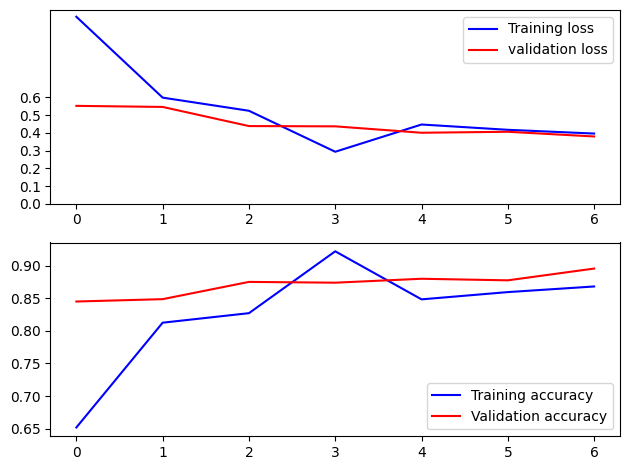

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Evaluate the test

To evaluate the performance of our model we will create a test generator to load the images from the input data directory and evaluate the results.

In [18]:
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False 
)

Found 378 validated image filenames belonging to 8 classes.


In [19]:
filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate(test_generator, steps=nb_samples)

print('Accuracy on test set = ', round((accuracy * 100), 2), '%')

  4/378 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - categorical_accuracy: 1.0000 - loss: 0.0693 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


378/378 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - categorical_accuracy: 0.8944 - loss: 0.3563
Accuracy on test set =  88.1 %


In [20]:
# We defined at the beginning of this notebook a dictionary that maps the categories number to names, but the train generator
# generated it's own dictionary and it has assigned different numbers to our categories and the predictions made by the model 
# will be made using the genrator's dictionary.

gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

{0: 'brown-glass', 1: 'cardboard', 2: 'green-glass', 3: 'metal', 4: 'paper', 5: 'plastic', 6: 'trash', 7: 'white-glass'}


In [21]:
# get the model's predictions for the test set
preds = model.predict(test_generator, nb_samples)

# Get the category with the highest predicted probability, the prediction is only the category's number and not name
preds = preds.argmax(1)

# Convert the predicted category's number to name 
preds = [gen_label_map[item] for item in preds]

# Convert the pandas dataframe to a numpy matrix
labels = test_df['category'].to_numpy()

print(classification_report(labels, preds))

378/378 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step
              precision    recall  f1-score   support

 brown-glass       0.88      0.84      0.86        25
   cardboard       0.95      0.86      0.90        49
 green-glass       0.98      0.93      0.95        45
       metal       0.90      0.90      0.90        48
       paper       0.86      0.96      0.91        70
     plastic       0.80      0.84      0.82        57
       trash       0.91      0.93      0.92        46
 white-glass       0.79      0.71      0.75        38

    accuracy                           0.88       378
   macro avg       0.88      0.87      0.88       378
weighted avg       0.88      0.88      0.88       378



In [22]:
# Get the model's predictions
preds = model.predict(test_generator, steps=len(test_generator))

# Get the category with the highest predicted probability
preds_indices = preds.argmax(1)

# Convert predicted indices to category names
class_names = list(train_generator.class_indices.keys())
preds_names = [class_names[idx] for idx in preds_indices]

# Get true labels
true_labels = test_df['category'].to_numpy()

# Print classification report
print(classification_report(true_labels, preds_names))

378/378 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step
              precision    recall  f1-score   support

 brown-glass       0.88      0.84      0.86        25
   cardboard       0.95      0.86      0.90        49
 green-glass       0.98      0.93      0.95        45
       metal       0.90      0.90      0.90        48
       paper       0.86      0.96      0.91        70
     plastic       0.80      0.84      0.82        57
       trash       0.91      0.93      0.92        46
 white-glass       0.79      0.71      0.75        38

    accuracy                           0.88       378
   macro avg       0.88      0.87      0.88       378
weighted avg       0.88      0.88      0.88       378



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


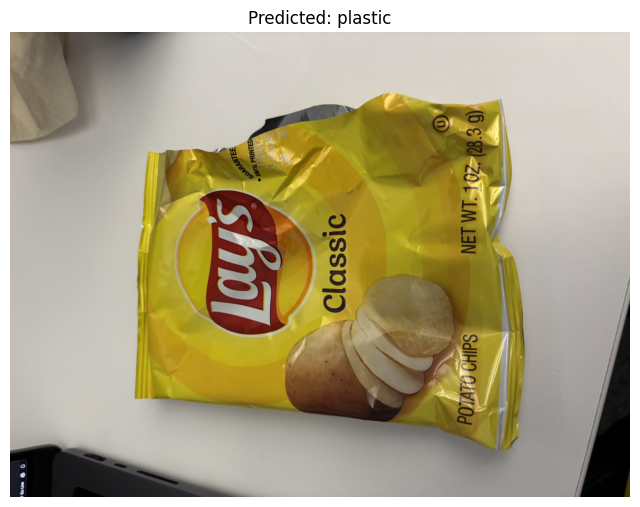

In [56]:
def show_classification_result(image_path, true_label, predicted_label):
    img = Image.open(image_path)
    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label}")
    plt.show()

# Assuming you want to use the test generator
image_path = '/Users/benji/Downloads/IMG_0916.jpeg'

# Get class names
class_names = list(train_generator.class_indices.keys())

# Predict for this specific image
img = Image.open(image_path)
img = img.resize(IMAGE_SIZE)  # Ensure correct image size
img_array = np.expand_dims(img, axis=0)  # Add batch dimension
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]

# You'll need to manually specify the true label for this image
true_label = 'Plastic'  # Replace with the actual label

show_classification_result(image_path, true_label, predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


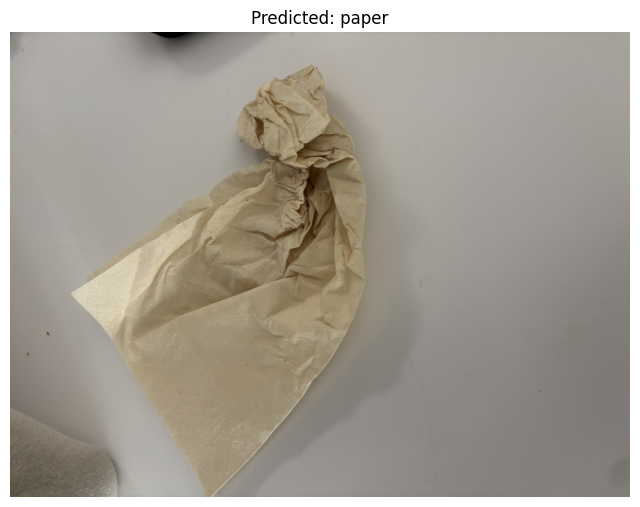

In [54]:
# Assuming you want to use the test generator
image_path = '/Users/benji/Downloads/IMG_0914.jpeg'

# Get class names
class_names = list(train_generator.class_indices.keys())

# Predict for this specific image
img = Image.open(image_path)
img = img.resize(IMAGE_SIZE)  # Ensure correct image size
img_array = np.expand_dims(img, axis=0)  # Add batch dimension
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]

# You'll need to manually specify the true label for this image
true_label = 'Paper'  # Replace with the actual label

show_classification_result(image_path, true_label, predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


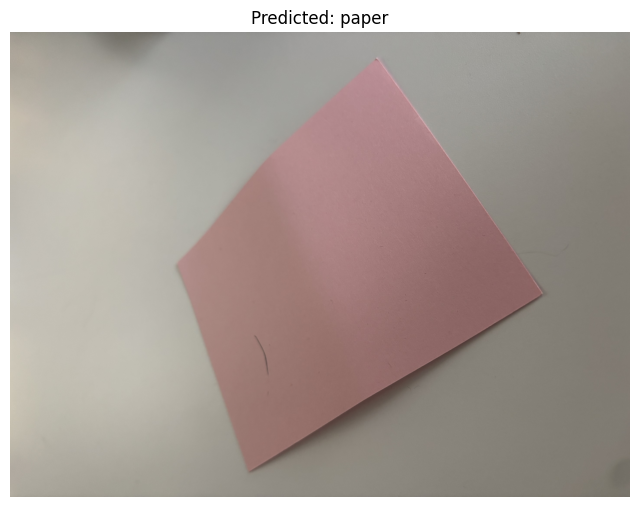

In [55]:
# Assuming you want to use the test generator
image_path = '/Users/benji/Downloads/IMG_0920.jpeg'

# Get class names
class_names = list(train_generator.class_indices.keys())

# Predict for this specific image
img = Image.open(image_path)
img = img.resize(IMAGE_SIZE)  # Ensure correct image size
img_array = np.expand_dims(img, axis=0)  # Add batch dimension
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]

# You'll need to manually specify the true label for this image
true_label = 'Paper'  # Replace with the actual label

show_classification_result(image_path, true_label, predicted_class)

In [27]:
import cv2
import os
from datetime import datetime

def capture_image():
    """
    Open webcam and capture an image when spacebar is pressed.
    
    Returns:
    str: Path to the captured image
    """
    # Initialize the webcam
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        raise IOError("Cannot open webcam")
    
    while True:
        # Read a frame from the webcam
        ret, frame = cap.read()
        
        # Display the video stream
        cv2.imshow('Webcam', frame)
        
        # Wait for spacebar key press
        key = cv2.waitKey(1)
        
        # Capture image when spacebar is pressed (key code 32)
        if key == 32:
            # Create images directory if it doesn't exist
            os.makedirs('captured_images', exist_ok=True)
            
            # Generate unique filename with timestamp
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            image_path = f'captured_images/image_{timestamp}.jpg'
            
            # Save the image
            cv2.imwrite(image_path, frame)
            
            # Close webcam windows
            cap.release()
            cv2.destroyAllWindows()
            
            print(f"Image saved to {image_path}")
            return image_path
        
        # Exit if 'q' is pressed
        elif key == ord('q'):
            break
    
    # Release the webcam and close windows
    cap.release()
    cv2.destroyAllWindows()
    return None

def process_image(image_path):
    """
    Example function to process the captured image.
    Replace with your specific image processing logic.
    
    Args:
    image_path (str): Path to the captured image
    """
    if image_path:
        print(f"Processing image: {image_path}")
        # Add your image processing code here
        # For example:
        # image = cv2.imread(image_path)
        # Perform analysis, transformations, etc.


    
    

In [ ]:
#Capture an image from webcam
captured_image_path = capture_image()

# If an image was captured, use its path for prediction
if captured_image_path:
    # Get class names
    class_names = list(train_generator.class_indices.keys())

    # Predict for the captured image
    img = Image.open(captured_image_path)
    img = img.resize(IMAGE_SIZE)  # Ensure correct image size
    img_array = np.expand_dims(img, axis=0)  # Add batch dimension
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]

    # You'll need to manually specify the true label for this image
    true_label = 'Paper'  # Replace with the actual label

    show_classification_result(captured_image_path, true_label, predicted_class)

: 